# Plot TNG Cluster analysis
## Written by Eric Rohr

In [1]:
### import modules
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.patheffects as pe
import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
import scipy.stats
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import os
import time
import h5py
import rohr_utils as ru 
import random
import six
%matplotlib inline 

plt.style.use('fullpage.mplstyle')

zs, times = ru.return_zs_costimes()
times /= 1.0e9 # [Gyr]
scales = 1. / (1.+ zs)

In [2]:
### set global variables and plotting kwargs
mass_binwidth = 0.1
time_binwidth = 0.5

NGaussSmooth = 1000

figsizewidth  = 6.902 # the textwidth in inches of MNRAS
figsizeratio = 9. / 16.
figsizeheight = figsizewidth * figsizeratio

figsizewidth_fullpage = figsizewidth
figsizeheight_fullpage = figsizewidth_fullpage * figsizeratio
figsizewidth_column = (244. / 508.) * figsizewidth
figsizeheight_column = figsizewidth_column * figsizeratio

gal_boundary = 0.15

hist_kwargs         = dict(histtype='step')
sc_kwargs           = dict(s=4**2, alpha=1.0, zorder=1.01, marker=r"$\rm{{{0:s}}}$".format('\u25EF'), linewidths=0.75)
plot_kwargs         = dict(fillstyle='none', ms=1, mew=0.75, alpha=0.1)
vline_kwargs        = dict(marker='None', ls='-', zorder=1, alpha=0.5, lw=1.0)
median_kwargs       = vline_kwargs.copy()
median_kwargs['lw'] = 2.0
text_kwargs         = dict()
axislabel_kwargs    = dict()
legend_kwargs       = dict()
one_one_kwargs      = dict(ls='-', marker='None', c='k', zorder=1.0, lw=2.5)
gal_boundary_kwargs = dict(marker='None', ls='--', c='k', zorder=0.9)

Mstarz0_key = 'Subhalo_Mstar_Rgal_z0'
M200cz0_key = 'HostGroup_M_Crit200_z0'
muz0_key    = 'muz0'
MCGasz0_key = 'SubhaloColdGasMass_z0'
MHGasz0_key = 'SubhaloHotGasMass_z0'
MTGasz0_key = 'SubhaloGasMass_z0'

Mstarz0_label   = r'$M_{\star}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
M200cz0_label   = r'$M_{\rm 200c}^{\rm host}(z=0)\, [{\rm M_\odot}]$'
muz0_label      = r'$\mu \equiv M_{\star}^{\rm sat} / M_{\rm 200c}^{\rm host} (z=0)$'
muz0_label_words = r'Mass Ratio $[\mu(z=0)]$'
MCGasz0_label   = r'$M_{\rm ColdGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
MHGasz0_label   = r'$M_{\rm HotGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
MTGasz0_label   = r'$M_{\rm TotGas}^{\rm sat}(z=0)\, [{\rm M_\odot}]$'
Nbranches_label = r'\# Galaxies' 

tau0_infall_HG_key = 'CosmicTime_tau_infall_HotGas0'
tau100_infall_HG_key = 'CosmicTime_tau_infall_HotGas100'
tau0_infall_G_key = 'CosmicTime_tau_infall_Gas0'
tau100_infall_G_key = 'CosmicTime_tau_infall_Gas100'
tau0_infall_CG_key = 'CosmicTime_tau_infall_ColdGas0'
tau100_infall_CG_key = 'CosmicTime_tau_infall_ColdGas100'

tstrip_infall_HG_key = 'Tstrip_tau_infall_HotGas_tau0-tau100'
tstrip_infall_CG_key = 'Tstrip_tau_infall_ColdGas_tau0-tau100'
tstrip_infall_AG_key = 'Tstrip_tau_infall_Gas_tau0-tau100'

tau0_infall_label = r'Cosmic Time at Infall [$\tau_0$] [Gyr]'
tau100_infall_HG_label = r'Cosmic Time at $\tau_{100}^{\rm HotGas}$ [Gyr]'
tau100_infall_CG_label = r'Cosmic Time at $\tau_{100}^{\rm ColdGas}$ [Gyr]'
tau100_infall_AG_label = r'Cosmic Time at $\tau_{100}^{\rm Gas}$ [Gyr]'

tstrip_infall_HG_label = r'Hot Gas Loss [$\tau_{100}^{\rm HotGas} - \tau_{0}$] [Gyr]'
tstrip_infall_CG_label = r'Hot Gas Loss [$\tau_{100}^{\rm ColdGas} - \tau_{0}$] [Gyr]'
tstrip_infall_AG_label = r'Hot Gas Loss [$\tau_{100}^{\rm Gas} - \tau_{0}$] [Gyr]'

tau0_key = tau0_infall_HG_key
infall_key = tau0_key
tau0_label = tau0_infall_label
infall_label = tau0_label
tau100_key = tau100_infall_HG_key
tau100_label = tau100_infall_HG_label
tstrip_key = tstrip_infall_HG_key
tstrip_label = tstrip_infall_HG_label
tstrip_label_long = r'Total Hot Gas Loss Duration [$\tau_{100}^{\rm HotGas} - \tau_{0}$] [Gyr]'

d0_RPS_tot_key = 'HostCentricDistance_norm_tau_infall_HotGas0'
d0_RPS_tot_label = r'Distance to $z=0$ Host at infall $[R_{\rm 200c}^{\rm host}({\rm infall})]$'

fgas_infall_key = 'SubhaloColdGasFraction_tau_RPS_tot0'
fgas_infall_label = r'$f_{\rm ColdGas}(\tau_0)\equiv M_{\rm ColdGas}^{\rm sat}(\tau_0) / M_{\star}^{\rm sat}(\tau_0)$'
SHGM_infall_key = 'SubhaloHotGasMass_tau_infall_HotGas0'
SHGM_infall_label = r'$M_{\rm HotGas}^{\rm sat}(\tau_0)$'

Napopass_tau100_key = 'Napopass_tau_infall_HotGas100'
Napopass_tau100_label = r'Number of Orbits'

HCDnz0_key = 'HostCentricDistance_norm_z0'


direc_list = ['../Figures/TNGCluster/']
direc_PP ='../Figures/TNGCluster/'
direc_list = [direc_PP]


In [3]:
# define plotting labels and kwargs for each taudcit_key, gasz0_key combination

all_key = 'all'
clean_key = 'clean'
PP_key = 'preprocessed'
taudict_keys = [all_key, clean_key, PP_key]

all_label = 'All'
clean_label = 'First-Infaller'
PP_label = 'Pre-Processed'
taudict_labels = [all_label, clean_label, PP_label]
taudict_labels_dict = {all_key:all_label, clean_key:clean_label, PP_key:PP_label}

tot_key = 'tot'
gas_key = 'gas'
nogas_key = 'nogas'
gasz0_keys = [tot_key, gas_key, nogas_key]

tot_label = 'All'
gas_label = r'$M_{\rm HotGas}^{\rm sat}(z=0) > 10^{7}\, {\rm M_\odot}$'
nogas_label = r'$M_{\rm HotGas}^{\rm sat}(z=0) < 10^{7}\, {\rm M_\odot}$'
gasz0_labels = [tot_label, gas_label, nogas_label]
gasz0_labels_dict = {tot_key:tot_label, gas_key:gas_label, nogas_key:nogas_label}

### define some general plotting parameters for each taudict_key, gasz0_key combination
### general colorscheme:
### jellyfish: green (for green valley galaxies, and images are typically green, blue and yellow)
### nonjellyf: purple (could be starforming and blue or quiescent and red)
### inspected: black 
### gasz0: blue, because they still have gas and are likely star forming
### nogasz0: red, because they have no gas and are quenched
### tot: the same color as standard

histkwargs_clean = dict(**hist_kwargs, color='tab:green', lw=2.5, zorder=2.2)
histkwargs_pp = dict(**hist_kwargs, color='tab:purple', lw=2.0, zorder=2.1)
histkwargs_all = dict(**hist_kwargs, color='silver', lw=3.5, zorder=1.9)
#histkwargs_all['histtype'] = 'bar'
histkwargs_dict_temp = {clean_key:histkwargs_clean, PP_key:histkwargs_pp, all_key:histkwargs_all}

histkwargs_dict = {}
for taudict_key in taudict_keys:
    histkwargs_dict[taudict_key] = {}
    for gasz0_key in gasz0_keys:
        histkwargs_dict[taudict_key][gasz0_key] = histkwargs_dict_temp[taudict_key].copy()
    histkwargs_dict[taudict_key][gas_key]['color'] = 'tab:blue'
    histkwargs_dict[taudict_key][nogas_key]['color'] = 'tab:red'


cmaps_dict_temp = {clean_key:mpl.cm.get_cmap('Greens'),
                   PP_key:mpl.cm.get_cmap('Purples'),
                   all_key:mpl.cm.get_cmap('Greys')}

cmaps_dict = {}
for taudict_key in taudict_keys:
    cmaps_dict[taudict_key] = {}
    for gasz0_key in gasz0_keys:
        cmaps_dict[taudict_key][gasz0_key] = cmaps_dict_temp[taudict_key].copy()
    cmaps_dict[taudict_key][gas_key] = mpl.cm.get_cmap('Blues')
    cmaps_dict[taudict_key][nogas_key] = mpl.cm.get_cmap('Reds')
    
    
## define histogram kwargs for binning tstrip by M200cz0, Mstarz0, or tau0_infall ###
### NB -- must have two sets of histogram kwargs for the two definitions of tstrip ###
sim = 'L680n8192TNG'
M200cz0_bins = [14.0, 14.5, 15.0, 15.5] 
Mstarz0_bins = [10.0, 10.5, 11.0, 12.0]
SCGM_infall_bins = [9.0, 9.5, 10., 10.5]
tau0_bins = [5.0, 7.5, 10.0, 12.5]
Norbit_bins = [0, 1, 2, 4]

tstrip_histkwargs_dict = {}
histkwargs_list_key = 'histkwargs_list'

# M200cz0
tstrip_histkwargs_dict[M200cz0_key] = dict(key=M200cz0_key, label=M200cz0_label,
                                           savelabel=r'm200cz0', bins=M200cz0_bins)

histkwargs_list    = [{}] * (len(M200cz0_bins) - 1)
histkwargs_list[0] = dict(**hist_kwargs, color='orangered', lw=1.5, zorder=1.05)
histkwargs_list[1] = dict(**hist_kwargs, color='red', lw=2.5, zorder=1.15)
histkwargs_list[2] = dict(**hist_kwargs, color='darkred', lw=3.5, zorder=1.25)
tstrip_histkwargs_dict[M200cz0_key][histkwargs_list_key] = histkwargs_list
    
# SCGM(infall)
histkwargs_list    = [{}] * (len(SCGM_infall_bins) - 1)
tstrip_histkwargs_dict[SHGM_infall_key] = dict(key=SHGM_infall_key, label=SHGM_infall_label,
                                               savelabel=r'SHGMinfall', bins=SCGM_infall_bins)
histkwargs_list[0] = dict(**hist_kwargs, color='darkorange', lw=2.0)
histkwargs_list[1] = dict(**hist_kwargs, color='orange', lw=1.5)
histkwargs_list[2] = dict(**hist_kwargs, color='wheat', lw=1.0)
tstrip_histkwargs_dict[SHGM_infall_key][histkwargs_list_key] = histkwargs_list

# Mstarz0
histkwargs_list = [{}] * (len(Mstarz0_bins) - 1)

tstrip_histkwargs_dict[Mstarz0_key] = dict(key=Mstarz0_key, label=Mstarz0_label,
                                           savelabel=r'mstarz0', bins=Mstarz0_bins)

histkwargs_list[0] = dict(**hist_kwargs, color='darkmagenta', lw=2.0)
histkwargs_list[1] = dict(**hist_kwargs, color='mediumpurple', lw=1.5)
histkwargs_list[2] = dict(**hist_kwargs, color='violet', lw=1.0)
tstrip_histkwargs_dict[Mstarz0_key][histkwargs_list_key] = histkwargs_list
      
# tau0_infall 
histkwargs_list  = [{}] * (len(tau0_bins) - 1)

tstrip_histkwargs_dict[tau0_key] = dict(key=tau0_key, label=tau0_label,
                                        savelabel='infalltime', bins=tau0_bins)

histkwargs_list[0] = dict(**hist_kwargs, color='darkgreen', lw=2.0)
histkwargs_list[1] = dict(**hist_kwargs, color='limegreen', lw=1.5)
histkwargs_list[2] = dict(**hist_kwargs, color='palegreen', lw=1.0)
tstrip_histkwargs_dict[tau0_key][histkwargs_list_key] = histkwargs_list

# Nubmer of completed orbits (== Number of apocenter passes)
tstrip_histkwargs_dict[Napopass_tau100_key] = {histkwargs_list_key:histkwargs_list.copy()}
tstrip_histkwargs_dict[Napopass_tau100_key]['bins'] = Norbit_bins
tstrip_histkwargs_dict[Napopass_tau100_key]['savelabel'] = 'Norbit'
tstrip_histkwargs_dict[Napopass_tau100_key]['label'] = Napopass_tau100_label
       
# add these dictionaries to the class
tstrip_histbins_dict = {tstrip_key:tstrip_histkwargs_dict}


In [4]:
class TNGSim:
    
    def __init__(self, sim, taudict_fname, taudict_key, gasz0_key,
                 tstrip_histbins_dict=tstrip_histbins_dict):
        """
        Initialize the TNGsim class.
        sim == 'TNG50-1' 
        taudict_key == jel_key, non_key, or ins_key
        gasz0_key == tot_key, gas_key, nogas_key
        M200cz0_bins, Mstarz0_bins should each be length 4, including all bin edges
        """ 
        self.sim  = sim
        self.M200cz0_bins= M200cz0_bins
        self.Mstarz0_bins = Mstarz0_bins
        self.taudict_fname = taudict_fname
        self.taudict_key = taudict_key
        self.gasz0_key = gasz0_key
        
        self.sim_label = 'TNG-Cluster'
        self.taudict_label = taudict_labels_dict[taudict_key]
        self.gasz0_label = gasz0_labels_dict[gasz0_key]
        
        #self.taudict_label = taudict_labels_dict[taudict_key]
        
        #self.gasz0_label = gasz0_labels_dict[gasz0_key]
                       
        # load the tau dictionary 
        self.tau_dict = load_taudict(self, taudict_fname)
        
        self.histkwargs = histkwargs_dict[taudict_key][gasz0_key]
        self.cmap = cmaps_dict[taudict_key][gasz0_key]
        self.plotkwargs = dict(**plot_kwargs, color=self.histkwargs['color'])
        
        sckwargs_dict = {}
        sckwargs_dict[M200cz0_key] = dict(**sc_kwargs, cmap='plasma',
                                          norm=mpl.colors.LogNorm(vmin=10.**min(M200cz0_bins), vmax=10.**(max(M200cz0_bins))))
        sckwargs_dict[Mstarz0_key] = dict(**sc_kwargs, cmap='viridis',
                                          norm=mpl.colors.LogNorm(vmin=10.**(min(Mstarz0_bins)), vmax=10.**(max(Mstarz0_bins))))
        sckwargs_dict[muz0_key]    = dict(**sc_kwargs, cmap='cubehelix_r',
                                          norm=mpl.colors.LogNorm(vmin=10.**(-5.5), vmax=10.**(-2.5)))
        self.sckwargs_dict = sckwargs_dict
        
        self.tstrip_histbins_dict = tstrip_histbins_dict
        
        self.save_label = sim + '_' + taudict_key + '_' + gasz0_key
        self.plot_label = '%s %s \n %s (%d)'%(self.sim_label, self.taudict_label, self.gasz0_label, self.tau_dict['SubfindID'].size)
        
        self.M200cz0_bins= M200cz0_bins
        
        return

def load_taudict(Sim, fname):

    result = {}
    with h5py.File('../Output/%s_subfindGRP/'%Sim.sim + fname, 'a') as f:
        group = f['Group']
        for dset_key in group.keys():
            result[dset_key] = group[dset_key][:]
        f.close()
        
    return result
        
    
def add_redshift_sincez2(ax, label=True):
    """
    For a given x axis, add redshift since z=2 to the top x-axis. 
    Optionally label the axis + tick marks.
    Returns ax
    """
    ticks_SnapNum = [33, 40, 50, 59, 67, 78, 84, 91, 99]
    ticks_costime = times[ticks_SnapNum]
    ticks_labels = ['2', '1.5', '1', '0.7', '0.5', '0.3', '0.2', '0.1', '0']

    xlolim = ru.floor_to_value(times[np.argmin(abs(zs - 2.5))], 0.1)
    xhilim = ru.ceil_to_value(times[np.argmin(abs(zs - 0.0))], 0.1)
    xhilim = 14.1

    ax.set_xlim(xlolim, xhilim)

    redshift_ax = ax.twiny()
    redshift_ax.set_xlim(ax.get_xlim())
    redshift_ax.set_xticks(ticks_costime)
    redshift_ax.tick_params(axis='both', which='minor', top=False)
    
    yscale = ax.get_yscale()
    if yscale == 'log':
        locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
        ax.yaxis.set_minor_locator(locmin)
        #ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

    if label:
        redshift_ax.set_xlabel(r'Redshift', **axislabel_kwargs)
        redshift_ax.set_xticklabels(ticks_labels)
    else:
        redshift_ax.set_xticklabels([])
        
    return ax



In [5]:
sim = 'L680n8192TNG'
fname = 'subfind_L680n8192TNG_tau.hdf5'
TNGCluster_all = TNGSim(sim, fname, all_key, tot_key)

fname = 'subfind_L680n8192TNG_tau_clean.hdf5'
TNGCluster_clean = TNGSim(sim, fname, clean_key, tot_key)

fname = 'subfind_L680n8192TNG_tau_preprocessed.hdf5'
TNGCluster_PP = TNGSim(sim, fname, PP_key, tot_key)

fname = 'subfind_L680n8192TNG_tau_gasz0.hdf5'
TNGCluster_all_gasz0 = TNGSim(sim, fname, all_key, gas_key)

fname = 'subfind_L680n8192TNG_tau_nogasz0.hdf5'
TNGCluster_all_nogasz0 = TNGSim(sim, fname, all_key, nogas_key)

fname = 'subfind_L680n8192TNG_tau_clean_gasz0.hdf5'
TNGCluster_clean_gasz0 = TNGSim(sim, fname, clean_key, gas_key)

fname = 'subfind_L680n8192TNG_tau_clean_nogasz0.hdf5'
TNGCluster_clean_nogasz0 = TNGSim(sim, fname, clean_key, nogas_key)

fname = 'subfind_L680n8192TNG_tau_preprocessed_gasz0.hdf5'
TNGCluster_PP_gasz0 = TNGSim(sim, fname, PP_key, gas_key)

fname = 'subfind_L680n8192TNG_tau_preprocessed_nogasz0.hdf5'
TNGCluster_PP_nogasz0 = TNGSim(sim, fname, PP_key, nogas_key)

all_Sims = [TNGCluster_all, TNGCluster_clean, TNGCluster_PP,
           TNGCluster_all_gasz0, TNGCluster_all_nogasz0, 
           TNGCluster_clean_gasz0, TNGCluster_clean_nogasz0,
           TNGCluster_PP_gasz0, TNGCluster_PP_nogasz0]

In [6]:
fgas_z0_key = 'fgas_z0'
fCgas_z0_key = 'fCgas_z0'
fHgas_z0_key = 'fHGas_z0'

SubhaloMassz0_key = 'SubhaloMass_z0'

fgas_z0_keys = [fgas_z0_key,
                fCgas_z0_key,
                fHgas_z0_key]

SubhaloGasMassz0_keys = [MTGasz0_key,
                        MCGasz0_key,
                        MHGasz0_key]

time_since_infall_key = 'TimeSinceInfall'

def add_fgas_dset(Sim):
    """
    Add dataset to tau_dict.
    """
    tau_dict = Sim.tau_dict
    SubhaloMassz0 = tau_dict[SubhaloMassz0_key]
    
    result = np.zeros(SubhaloMassz0.size, SubhaloMassz0.dtype)
    
    for i, fgas_z0_key in enumerate(fgas_z0_keys):
        dset = result.copy()
        gas_mass_key = SubhaloGasMassz0_keys[i]
        gas_mass = tau_dict[gas_mass_key]
        mask = gas_mass > 0
        dset[mask] = gas_mass[mask] / SubhaloMassz0[mask]
        tau_dict[fgas_z0_key] = dset
        
    return
        
def add_time_since_infall_dset(Sim):
    """
    Add dataset to tau_dict.
    """
    tau_dict = Sim.tau_dict
    tau0 = tau_dict[tau0_infall_HG_key]
    result = np.zeros(tau0.size, tau0.dtype)
    indices = tau0 > 0
    time_z0 = tau_dict['CosmicTime_z0'][indices][0]
    result[indices] = time_z0 - tau0[indices]
    tau_dict[time_since_infall_key] = result
    
    return
    
Sims = [TNGCluster_all, TNGCluster_clean, TNGCluster_PP]
for Sim in all_Sims:
    add_fgas_dset(Sim)
    add_time_since_infall_dset(Sim)




In [7]:
tau_dict = TNGCluster_all.tau_dict
Mstarz0 = tau_dict[Mstarz0_key]
Mstarz0.size, Mstarz0[Mstarz0 > 10.**(10.5)].size, Mstarz0[Mstarz0 > 10.**(11.0)].size, Mstarz0[Mstarz0 > 10.**(11.5)].size

(33932, 14404, 3893, 864)

In [8]:
print(TNGCluster_all.tau_dict['SubfindID'].size, TNGCluster_clean.tau_dict['SubfindID'].size, TNGCluster_PP.tau_dict['SubfindID'].size)
print(TNGCluster_all_gasz0.tau_dict['SubfindID'].size, TNGCluster_all_nogasz0.tau_dict['SubfindID'].size, TNGCluster_clean_gasz0.tau_dict['SubfindID'].size, TNGCluster_clean_nogasz0.tau_dict['SubfindID'].size)
print(TNGCluster_PP_gasz0.tau_dict['SubfindID'].size, TNGCluster_PP_nogasz0.tau_dict['SubfindID'].size)

33932 16109 17823
5159 28773 2763 13346
2092 15731


In [9]:
### 1D histogram plots binned by taudict_keys (jellyfish, nonjellyf, inspected) ###
def plot_tracers_mass_distributions_z0(Sims, savefig=False):
    """
    Plot the 1D histograms for 6 panels defined below. Could be generalized...
    Sims should be a list of TNGSim classes, starting with the broadest possible sample (i.e., inspected, tot)
    """

    x_keys   = [Mstarz0_key, M200cz0_key, muz0_key, MCGasz0_key, MHGasz0_key, MTGasz0_key]
    x_labels = [Mstarz0_label, M200cz0_label, muz0_label, MCGasz0_label, MHGasz0_label, MTGasz0_label]
    
    fig, axs = plt.subplots(2, 3, sharey='row')
    axs[0,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    axs[1,0].set_ylabel(Nbranches_label, **axislabel_kwargs)
    
    axs, legend_handels = plot_1Dhistograms(Sims, axs, x_keys, x_labels, y_step=0.15)
    for ax in axs.flatten():
        ax = plot_all_logticks(ax, plot_minor_ticks=True)
    
    fig.legend(handles=legend_handels, ncol=len(Sims), bbox_to_anchor=(0.5, 1.05), loc='lower center', bbox_transform=axs[0,1].transAxes,
               title=Sims[0].sim_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_massdistributions_z0.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, axs

def plot_1Dhistograms(Sims, axs, x_keys, x_labels,
                      x_text=0.05, y_text=0.95, y_step=0.1, ha='left', va='top',
                      plot_mask=True):
    """
    fill the panels for 1D histograms and return fig, ax, and legend_handels
    Also adds the number of points with x <= 0. 
    """
    if isinstance(x_keys, six.string_types):
        x_keys = [x_keys]
    if isinstance(x_labels, six.string_types):
        x_labels = [x_labels]
    
    if len(axs.flat) != len(x_keys) or len(axs.flat) != len(x_labels):
        print('Incorrect number of axs, x_keys, or x_labels. Retunrning')
        return
    
    for ax_i, ax in enumerate(axs.flat):
        x_key   = x_keys[ax_i]
        x_label = x_labels[ax_i]
        ax.set_xlabel(x_label, **axislabel_kwargs)
        ax.set_yscale('log')

        ax = plot_1Dhist_panel(Sims, ax, x_key, plot_mask=plot_mask) 
                
    # generate legend handels 
    legend_handels = add_histlegend(Sims)
    
    return axs, legend_handels
 
def plot_1Dhist_panel(Sims, ax, x_key,
                      plot_mask=True):
    """
    Calculate the 1D histogram and add to an existing axis.
    Loop over the taudict_keys and add each to the same axis.
    For the x values <= 0, there's the option either to plot them 
    at 1.0e-2 * min(x), or to omit them entirely. 
    Returns the ax and the number of points where x <= 0
    """
    
    ### use the first Sim to set the bins ###
    x = Sims[0].tau_dict[x_key].copy()
    
    # log bins (for mass quantities) or linear bins (for time quantities)
    if (tau100_key in x_key):
        x_loval = 0
        mask = x <= x_loval
        min_plot = x.max()
        x[mask] = min_plot
        binwidth = time_binwidth
        bins, bincents = ru.returnbins(x, binwidth)
    elif (tstrip_key in x_key):
        x_loval = 0.1
        mask = x <= x_loval
        min_plot = -10.
        x[mask] = min_plot
        binwidth = time_binwidth
        bins, bincents = ru.returnbins(x, binwidth)
    elif ('T' in x_key) or ('tau' in x_key):
        x_loval = 0.1
        mask = x <= x_loval
        min_plot = 0.
        x[mask] = min_plot
        binwidth  = time_binwidth
        bins, bincents = ru.returnbins(x, binwidth)
    elif ('M' in x_key):
        x_loval = 9.0e6
        mask = x <= x_loval
        min_plot = 1.0e6
        x[mask] = min_plot
        binwidth = mass_binwidth
        bins, bincents = ru.returnlogbins(x, binwidth) 
        ax.set_xscale('log')
    elif ('mu' in x_key):
        x_loval = 1.0e-7
        mask = x <= x_loval
        min_plot = x_loval
        x[mask] = min_plot
        binwidth = mass_binwidth
        bins, bincents = ru.returnlogbins(x, binwidth) 
        ax.set_xscale('log')
        
    for Sim in Sims:
        # load dataset and validate
        x = Sim.tau_dict[x_key].copy()
        mask = x <= x_loval
        print(Sim.save_label, mask.size, mask[mask].size)

        if plot_mask:
            x[mask] = min_plot
        else:
            x = x[~mask]
            
        label = Sim.gasz0_key + ' (%d)'%len(x)
        histkwargs = Sim.histkwargs

        ax.hist(x, bins, label=label, **histkwargs)
    # finish loop over Sims
        
    return ax


def add_histlegend(Sims):
    """
    generates the legend handles for the histogram plots, including the
    total number of points contained in the histogram
    """
    result = []
    for Sim in Sims:
        histkwargs = Sim.histkwargs
        label = Sim.taudict_label + ' (%d)'%(Sim.tau_dict[M200cz0_key].size)
        result.append(Patch(facecolor='None', edgecolor=histkwargs['color'],
                            lw=histkwargs['lw'], label=label))
    return result


def plot_all_logticks(ax, x_axis=True, plot_minor_ticks=False):
    """
    helper function that ensures that each base 10 power is shown.
    assumes to be run on x-axis, but functions similarly for y-axis.
    """
    if x_axis:
        x_lims = ax.get_xlim()
        x_lolog = ru.ceil_to_value(np.log10(x_lims[0]), 1.0)
        x_hilog = ru.floor_to_value(np.log10(x_lims[1]), 1.0)
        Ndex = x_hilog - x_lolog + 1
        
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numdecs=Ndex, numticks=Ndex))
        if plot_minor_ticks:
            locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
            ax.xaxis.set_minor_locator(locmin)
            
    else:
        ylims = ax.get_ylim()
        y_lolog = ru.ceil_to_value(np.log10(y_lims[0]), 1.0)
        y_hilog = ru.floor_to_value(np.log10(y_lims[1]), 1.0)
        Ndex = yhilog - y_lolog + 1

        ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10, numdecs=Ndex, numticks=Ndex))
        if plot_minor_ticks:
            locmin = mpl.ticker.LogLocator(subs=(0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9))
            ax.yaxis.set_minor_locator(locmin)
            
    return ax

    

In [10]:
savefig=False

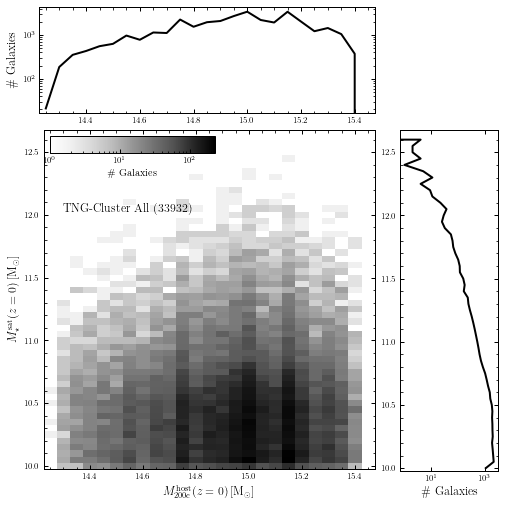

In [11]:
Sim = TNGCluster_all
tau_dict = Sim.tau_dict

x_key = M200cz0_key
y_key = Mstarz0_key

x_label = M200cz0_label
y_label = Mstarz0_label

x = np.log10(tau_dict[x_key])
y = np.log10(tau_dict[y_key])

indices = (x > 0) & (y > 0)

binwidth = 0.05

x_bins, x_bincents = ru.returnbins(x, binwidth)
y_bins, y_bincents = ru.returnbins(y, binwidth)    

# generate 2D histogram and smooth values
hist = np.histogram2d(x[indices], y[indices], bins=[x_bins, y_bins])
vals = hist[0].T
x_hist = np.sum(vals, axis=0)
y_hist = np.sum(vals, axis=1)

fig = plt.figure(constrained_layout=True, figsize=(figsizewidth,figsizewidth))
gs0 = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1.0, 0.33], height_ratios=[0.33, 1.0], hspace=0, wspace=0)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0,0])
ax00 = fig.add_subplot(gs00[0])
ax00.set_ylabel(Nbranches_label)
ax00.set_yscale('log')
ax00.plot(x_bincents, x_hist, marker='None', ls='-')
#ax00.set_xscale('log')
#ax00.set_xticklabels([])

gs10 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1,0])
ax10 = fig.add_subplot(gs10[0], sharex=ax00)
ax10.set_ylabel(y_label)
ax10.set_xlabel(x_label)
#ax10.set_yscale('log')
#ax10.set_xscale('log')
#ax10.imshow(vals, origin='lower', extent=[x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()])
h = ax10.hist2d(x, y, bins=(x_bins, y_bins), cmap='Greys', norm=mpl.colors.LogNorm())

cax10 = inset_axes(ax10, width='50%', height='5%', loc='upper left')
cbar = plt.colorbar(h[3], cax=cax10, orientation='horizontal')
cbar.set_label(Nbranches_label, labelpad=5, fontsize='small')
cbar.ax.tick_params(labelsize='x-small')
        
ax10.text(14.3, 12.1, 'TNG-Cluster All (%d)'%(x.size),
          va='top', ha='left')

gs11 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1,1])
ax11 = fig.add_subplot(gs11[0], sharey=ax10)
ax11.set_xlabel(Nbranches_label)
ax11.set_xscale('log')
ax11.plot(y_hist, y_bincents, marker='None', ls='-')
#ax11.set_yscale('log')
#ax11.set_yticklabels([])

fname = '%s_massdistribtuions_z0.pdf'%Sim.save_label
if (savefig):
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight')


In [40]:
tau_dict.keys()

dict_keys(['CosmicTime_tau_infall_ColdGas0', 'CosmicTime_tau_infall_ColdGas100', 'CosmicTime_tau_infall_Gas0', 'CosmicTime_tau_infall_Gas100', 'CosmicTime_tau_infall_HotGas0', 'CosmicTime_tau_infall_HotGas100', 'CosmicTime_tau_medpeak_ColdGas0', 'CosmicTime_tau_medpeak_ColdGas100', 'CosmicTime_tau_medpeak_Gas0', 'CosmicTime_tau_medpeak_Gas100', 'CosmicTime_tau_medpeak_HotGas0', 'CosmicTime_tau_medpeak_HotGas100', 'CosmicTime_z0', 'HostCentricDistance_norm_tau_infall_ColdGas0', 'HostCentricDistance_norm_tau_infall_ColdGas100', 'HostCentricDistance_norm_tau_infall_Gas0', 'HostCentricDistance_norm_tau_infall_Gas100', 'HostCentricDistance_norm_tau_infall_HotGas0', 'HostCentricDistance_norm_tau_infall_HotGas100', 'HostCentricDistance_norm_tau_medpeak_ColdGas0', 'HostCentricDistance_norm_tau_medpeak_ColdGas100', 'HostCentricDistance_norm_tau_medpeak_Gas0', 'HostCentricDistance_norm_tau_medpeak_Gas100', 'HostCentricDistance_norm_tau_medpeak_HotGas0', 'HostCentricDistance_norm_tau_medpeak_HotG

L680n8192TNG_all_tot 33932 0
L680n8192TNG_clean_tot 16109 0
L680n8192TNG_preprocessed_tot 17823 1
L680n8192TNG_all_tot 33932 0
L680n8192TNG_clean_tot 16109 0
L680n8192TNG_preprocessed_tot 17823 1
L680n8192TNG_all_tot 33932 0
L680n8192TNG_clean_tot 16109 0
L680n8192TNG_preprocessed_tot 17823 0
L680n8192TNG_all_tot 33932 29112
L680n8192TNG_clean_tot 16109 13470
L680n8192TNG_preprocessed_tot 17823 15642
L680n8192TNG_all_tot 33932 28593
L680n8192TNG_clean_tot 16109 13173
L680n8192TNG_preprocessed_tot 17823 15420
L680n8192TNG_all_tot 33932 28556
L680n8192TNG_clean_tot 16109 13158
L680n8192TNG_preprocessed_tot 17823 15398


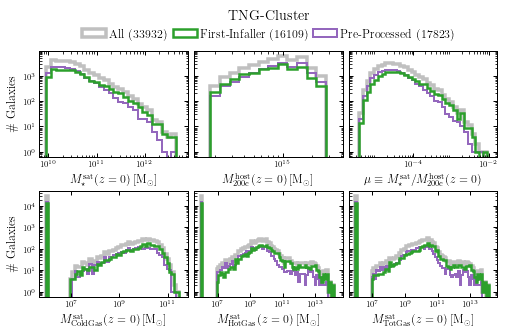

In [12]:
Sims = [TNGCluster_all, TNGCluster_clean, TNGCluster_PP]

fig, axs = plot_tracers_mass_distributions_z0(Sims, savefig=savefig)

In [13]:
tau_dict = TNGCluster_all.tau_dict
MHGasz0 = tau_dict[MHGasz0_key]
mask = MHGasz0 < 1.0e7
mask.size, mask[mask].size, mask[~mask].size

(33932, 28598, 5334)

In [14]:
tau_dict = TNGCluster_PP.tau_dict
MHGasz0 = tau_dict[MHGasz0_key]
mask = MHGasz0 < 1.0e7
mask.size, mask[mask].size, mask[~mask].size

(17823, 15424, 2399)

In [15]:
tau_dict = TNGCluster_PP_gasz0.tau_dict
MHGasz0 = tau_dict[MHGasz0_key]
mask = MHGasz0 < 1.0e7
mask.size, mask[mask].size, mask[~mask].size

(2092, 7, 2085)

In [16]:
tau_dict = TNGCluster_PP_nogasz0.tau_dict
MHGasz0 = tau_dict[MHGasz0_key]
mask = MHGasz0 < 1.0e7
mask.size, mask[mask].size, mask[~mask].size

(15731, 15417, 314)

In [17]:
def plot_2dhist_smoothed(Sim, ax, x_key, y_key,
                         loc='lower right'):
    """
    fill an ax with a gaussian smoothed 2d histogram of a given taudict_key (jellyfish, nonjellyf, inspected).
    requires the x the y keys for Sim.tau_dict[taudict_key], and optionally the location of the colorbar.
    Assumes equal bins for the x and y data, and plots the one to one line. used for comparing two definitions.
    returns the ax.
    """
    
    tau_dict = Sim.tau_dict
    
    x = tau_dict[x_key]
    y = tau_dict[y_key]
    
    indices = (x > 0) & (y > 0)
    
    # log bins (for mass quantities) or linear bins (for time quantities)
    if 'Tstrip' in x_key:
        binwidth = time_binwidth
        bins, bincents = ru.returnbins([0.01, 9.99], 0.3)
    elif 'T' in x_key:
        binwidth  = time_binwidth
        bins, bincents = ru.returnbins([0.01, 13.9], 0.3)
    elif ('M' in x_key) or ('mu' in x_key):
        binwidth = mass_binwidth
        ax.set_xscale('log')
        bins, bincents = ru.returnlogbins(y, binwidth)      
        
    # generate 2D histogram and smooth values
    hist = np.histogram2d(x[indices], y[indices], bins=bins)
    vals = gaussian_filter(hist[0].T, 1.0)
    
    # plot contours based on percentiles of the smoothed values
    percentiles = [50, 75, 90, 97]
    levels = np.zeros(len(percentiles))
    for i, p in enumerate(percentiles):
        levels[i] = np.percentile(vals[vals > 0], p)
        
    # plot the filled contours
    ax.contour(bincents, bincents, vals, levels=levels, cmap=Sim.cmap, extend='both')
    cs = ax.contourf(bincents, bincents, vals, levels=levels, cmap=Sim.cmap, extend='both')
    
    # add the colorbar 
    cax = inset_axes(ax, width='50%', height='5%', loc=loc) 
    cbar = plt.colorbar(cs, cax=cax, orientation='horizontal')
    cbar.set_label(r'Percentiles', labelpad=5, fontsize='small')
    cax.set_xticklabels(['%d'%(100-p) for p in percentiles])
    cbar.ax.tick_params(labelsize='x-small')
    cax.minorticks_off()
    if loc == 'lower right':
        cax.xaxis.set_label_position('top')
        cax.xaxis.set_ticks_position('top')
        
    ax.set_title('%s (%d)'%(Sim.plot_label, x[indices].size), fontsize='medium')
        
    return ax


In [18]:
def plot_time_distributions(Sims,
                            x_keys=[tau0_key, tau100_key, tstrip_key],
                            x_labels=[tau0_label, tau100_label, tstrip_label],
                            savefig=False, legend=True):
    """
    Plot 1d histogram distributions for the given x quantities
    Default is tau0, tau100, tauRPS for the standard definition.
    """
    
    if len(x_keys) != len(x_labels):
        print('Wrong number of x_keys or x_labels.')
        return
    
    fig, axs = plt.subplots(1, len(x_keys), sharey=True, figsize=(figsizewidth, figsizewidth/2.5))
    axs[0].set_ylabel(Nbranches_label, **axislabel_kwargs)
        
    if 'Tstrip' in x_keys[0]:
        x_text = 0.95
        ha = 'right'
        save_key = 'tstrip'
    elif 'T' in x_keys[0]:
        x_text = 0.05
        ha = 'left'
        save_key = 'taus'
        
    axs, _ = plot_1Dhistograms(Sims, axs, x_keys, x_labels,
                               y_step=0.10, x_text=x_text, ha=ha, plot_mask=True)
        
    axs[0] = add_redshift_sincez2(axs[0])
    axs[1] = add_redshift_sincez2(axs[1])
    axs[2].set_xlim(-0.5, 10.1)
    
    ### add some extra info and text
    # axs[0]: clarify tau0 == infall time
    text = r'$\tau_0 \equiv$ infall time'
    textkwargs = dict(ha='left', va='top', transform=axs[0].transAxes, **text_kwargs)
    text = axs[0].text(0.05, 0.95, text, **textkwargs)
        
    # axs[1]: state the Mstar and M200c ranges for each sample
    """
    textkwargs = dict(ha='left', va='top', ma='left', transform=axs[1].transAxes, **text_kwargs)
    xval = 0.05
    yval = 0.95
    ystep = 0.11
    ymstar = yval - ystep
    ym200c = ymstar - ystep * 3
    for i, Sim in enumerate(Sims):
        if i == 0:
            axs[1].text(xval, yval, r'at $z=0:$', **textkwargs)
            axs[1].text(xval, ymstar, r'$\lg[M_{\star}^{\rm sat}] \in$', **textkwargs)
            axs[1].text(xval, ym200c, r'$\lg[M_{\rm 200c}^{\rm host}] \in$', **textkwargs)
        c = Sim.plotkwargs['color']
        mstarlolim = ru.floor_to_value(np.log10(Sim.tau_dict[Mstarz0_key].min()), 0.1)
        mstarhilim = ru.ceil_to_value(np.log10(Sim.tau_dict[Mstarz0_key].max()), 0.1)
        m200clolim = ru.floor_to_value(np.log10(Sim.tau_dict[M200cz0_key].min()), 0.1)
        m200chilim = ru.ceil_to_value(np.log10(Sim.tau_dict[M200cz0_key].max()), 0.1)
        axs[1].text(xval, ymstar - ystep*(i + 1), r'$(%.1f, %.1f)$'%(mstarlolim, mstarhilim), c=c, **textkwargs)
        axs[1].text(xval, ym200c - ystep*(i + 1), r'$(%.1f, %.1f)$'%(m200clolim, m200chilim), c=c, **textkwargs)
    """
        
    if legend:
        legend_handels = add_histlegend_gasz0(Sims)
        fig.legend(handles=legend_handels, ncol=2, bbox_to_anchor=(0.5, 1.15), loc='lower center', bbox_transform=axs[1].transAxes,
                   title=Sims[0].sim_label + ' ' + Sims[0].taudict_label, title_fontsize='large', **legend_kwargs)
    
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_tau_distributions.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
            
    return fig, axs

def add_histlegend_gasz0(Sims):
    """
    generates the legend handles for the histogram plots, including the
    total number of points contained in the histogram
    """
    result = []
    for Sim in Sims:
        histkwargs = Sim.histkwargs
        tau_dict = Sim.tau_dict
        Nobjects = np.where(tau_dict[tau0_key] != -1)[0].size
        label = Sim.gasz0_label + ' (%d)'%Nobjects
        result.append(Patch(facecolor='None', edgecolor=histkwargs['color'],
                            lw=histkwargs['lw'], label=label))
    return result


L680n8192TNG_clean_nogas 13346 0
L680n8192TNG_clean_gas 2763 0
L680n8192TNG_preprocessed_nogas 15731 0
L680n8192TNG_preprocessed_gas 2092 1
L680n8192TNG_clean_nogas 13346 572
L680n8192TNG_clean_gas 2763 2763
L680n8192TNG_preprocessed_nogas 15731 503
L680n8192TNG_preprocessed_gas 2092 2092
L680n8192TNG_clean_nogas 13346 595
L680n8192TNG_clean_gas 2763 2763
L680n8192TNG_preprocessed_nogas 15731 532
L680n8192TNG_preprocessed_gas 2092 2092
L680n8192TNG_all_nogas 28773 0
L680n8192TNG_all_gas 5159 0
L680n8192TNG_all_nogas 28773 5769
L680n8192TNG_all_gas 5159 5159
L680n8192TNG_all_nogas 28773 5771
L680n8192TNG_all_gas 5159 5159
L680n8192TNG_clean_nogas 13346 0
L680n8192TNG_clean_gas 2763 0
L680n8192TNG_clean_nogas 13346 572
L680n8192TNG_clean_gas 2763 2763
L680n8192TNG_clean_nogas 13346 595
L680n8192TNG_clean_gas 2763 2763
L680n8192TNG_preprocessed_nogas 15731 0
L680n8192TNG_preprocessed_gas 2092 1
L680n8192TNG_preprocessed_nogas 15731 503
L680n8192TNG_preprocessed_gas 2092 2092
L680n8192TNG_

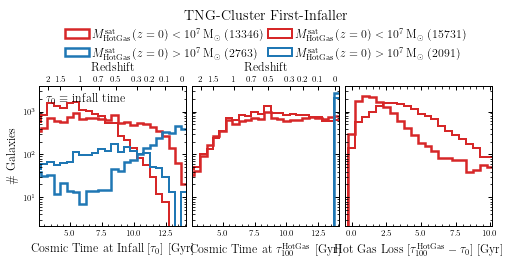

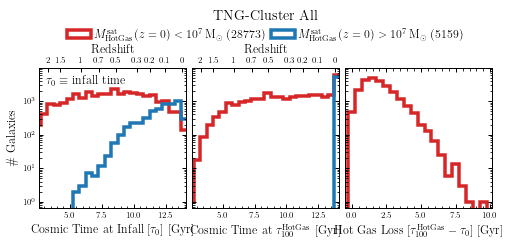

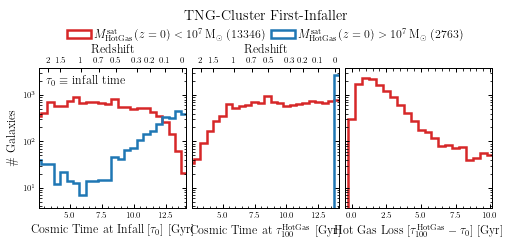

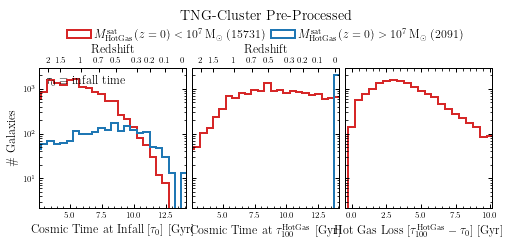

In [19]:

Sims = [TNGCluster_clean_nogasz0,
        TNGCluster_clean_gasz0,
        TNGCluster_PP_nogasz0,
        TNGCluster_PP_gasz0]

fig, axs = plot_time_distributions(Sims, savefig=savefig)

Sims = [TNGCluster_all_nogasz0,
        TNGCluster_all_gasz0]


fig, axs = plot_time_distributions(Sims, savefig=savefig)

Sims = [TNGCluster_clean_nogasz0,
        TNGCluster_clean_gasz0]

fig, axs = plot_time_distributions(Sims, savefig=savefig)

Sims = [TNGCluster_PP_nogasz0,
        TNGCluster_PP_gasz0]

fig, axs = plot_time_distributions(Sims, savefig=savefig)



In [20]:
Norbit = TNGCluster_all_nogasz0.tau_dict['Napopass_tau_infall_HotGas100']
print(Norbit[Norbit <= 0].size, Norbit[Norbit <= 0].size / Norbit.size)
print(Norbit[Norbit == 1].size, Norbit[Norbit == 1].size / Norbit[Norbit > 0].size)
print(Norbit[Norbit > 1].size, Norbit[Norbit > 1].size / Norbit.size)

22351 0.7768046432419282
5264 0.8196823419495485
1158 0.040246064018350534


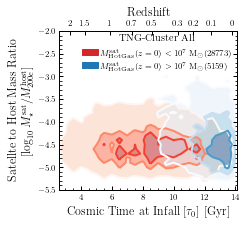

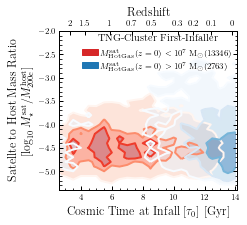

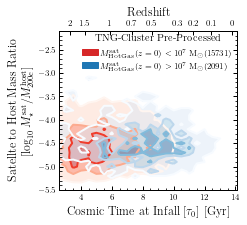

In [21]:
def plot_muz0_infalltimes_contours(Sims, savefig=False):
    """
    Plot muz0 vs infall time [tau_0] as contours for 
    each Sim in Sims. Sims should be a list of Sim classes.
    Optionally save the figure.
    Returns fig, ax
    """
    x_key = infall_key
    x_label = infall_label
    y_key = muz0_key
    y_label = 'Satellte to Host Mass Ratio \n' + r'[$\log_{10} M_{\star}^{\rm sat} / M_{\rm 200c}^{\rm host}$]'
    x_binwidth = 0.5
    y_binwidth = 0.1

    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizewidth_column / 1.1))
    ax.set_ylabel(y_label, **axislabel_kwargs)
    ax.set_xlabel(x_label, **axislabel_kwargs)
    ax = add_redshift_sincez2(ax, label=True)
    
    percentiles = [50, 84, 95, 100]
    
    patches = []
        
    for Sim in Sims:
        tau_dict = Sim.tau_dict

        x = tau_dict[x_key]
        y = np.log10(tau_dict[y_key])
        
        mask = x > 0
        y = y[mask]
        x = x[mask]
        
        x_bins, x_bincents = ru.returnbins(x, x_binwidth)
        y_bins, y_bincents = ru.returnbins(y, y_binwidth)
        c = np.ones(x.size)
        bins = [x_bins, y_bins]
    
        statistic = scipy.stats.binned_statistic_2d(y, x, c, statistic='count', bins=[bins[1], bins[0]])
        extent = [bins[0][0], bins[0][-1], 
                  bins[1][0], bins[1][-1]]        
        
        vals = statistic[0]

        # plot contours based on percentiles
        levels = np.zeros(len(percentiles))
        for i, p in enumerate(percentiles):
            levels[i] = np.percentile(vals[vals > 0], p)
        
        patches.append(Patch(color=Sim.histkwargs['color'], label=Sim.gasz0_label + '(%d)'%(x.size)))
        ax.contour(x_bincents, y_bincents, vals, levels=levels, cmap=Sim.cmap, extend=extent, alpha=1.0)
        ax.contourf(x_bincents, y_bincents, vals, levels=levels, cmap=Sim.cmap, extend=extent, alpha=0.5)

    ax.legend(handles=patches, title='%s %s'%(Sim.sim_label, Sim.taudict_label),
              title_fontsize='small', fontsize='x-small')

    
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_muz0_infalltime_contours.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, ax

def plot_muz0_infalltimes(Sims, savefig=False):
    """
    Plots muz0 vs infall time [tau_0] for each Sim in Sims
    Sims should be a list of Sim classes. 
    Optionally saves the figure.
    Returns fig, ax
    """

    x_key = infall_key
    x_label = infall_label
    y_key = muz0_key
    y_label = muz0_label_words

    fig, ax = plt.subplots(figsize=(figsizewidth_column, figsizewidth_column / 1.1))
    ax.set_yscale('log')
    ax.set_ylabel(y_label, **axislabel_kwargs)
    ax.set_xlabel(x_label, **axislabel_kwargs)
    ax = add_redshift_sincez2(ax, label=True)
    
    percentiles = [16, 50, 84]

    for Sim in Sims:
        tau_dict = Sim.tau_dict

        x = tau_dict[x_key]
        y = tau_dict[y_key]

        mask = (x > 0) & (y > 0)

        x_plot = x[mask]
        y_plot = y[mask]

        ax.plot(x_plot, y_plot, label=(Sim.gasz0_label + ' (%d)'%x_plot.size), **Sim.plotkwargs)
        x_16 = np.percentile(x_plot, 16)
        x_84 = np.percentile(x_plot, 84)
        y_16 = np.percentile(y_plot, 16)
        y_84 = np.percentile(y_plot, 84)
        ax.fill_between([x_16, x_84], y_16, y_84, color=Sim.plotkwargs['color'], alpha=0.3)
        x_50 = np.median(x_plot)
        y_50 = np.median(y_plot)
        ax.axvline(x_50, color=Sim.plotkwargs['color'], **median_kwargs)
        print('x16, 50, 84: %.2g %.2g %.2g'%(x_16, x_50, x_84))
        print('y16, 50, 84: %.2e %.2e %.2e'%(y_16, y_50, y_84))
        """
        for percentile in percentiles:
            val = np.percentile(x_plot, percentile)
            if percentile == 50:
                kwargs = median_kwargs
            else:
                kwargs = vline_kwargs
            ax.axvline(val, color=Sim.plotkwargs['color'], **kwargs)
        """

    leg_kwargs = dict(ncol=1, bbox_to_anchor=(0.5, 1.25), loc='lower center', bbox_transform=ax.transAxes,
                      title='%s %s'%(Sim.sim_label, Sim.taudict_label), title_fontsize='medium', fontsize='small')

    ax.legend(**leg_kwargs)   
    
    # axs[1]: state the Mstar and M200c ranges for each sample
    textkwargs = dict(ha='left', va='top', ma='left', transform=ax.transAxes, fontsize='xx-small', **text_kwargs)
    xval = -0.2
    yval = 1.65
    ystep = 0.09
    ymstar = yval
    ym200c = ymstar - ystep * 3.1
    for i, Sim in enumerate(Sims):
        if i == 0:
            #ax.text(xval, yval, r'at $z=0:$', **textkwargs)
            ax.text(xval, ymstar, r'$\lg[M_{\star}^{\rm sat}] \in$', **textkwargs)
            ax.text(xval, ym200c, r'$\lg[M_{\rm 200c}^{\rm host}] \in$', **textkwargs)
        c = Sim.plotkwargs['color']
        mstarlolim = ru.floor_to_value(np.log10(Sim.tau_dict[Mstarz0_key].min()), 0.1)
        mstarhilim = ru.ceil_to_value(np.log10(Sim.tau_dict[Mstarz0_key].max()), 0.1)
        m200clolim = ru.floor_to_value(np.log10(Sim.tau_dict[M200cz0_key].min()), 0.1)
        m200chilim = ru.ceil_to_value(np.log10(Sim.tau_dict[M200cz0_key].max()), 0.1)
        ax.text(xval, ymstar - ystep*(i + 1), r'$(%.1f, %.1f)$'%(mstarlolim, mstarhilim), c=c, **textkwargs)
        ax.text(xval, ym200c - ystep*(i + 1), r'$(%.1f, %.1f)$'%(m200clolim, m200chilim), c=c, **textkwargs)
        
    if (savefig):
        save_label = ''
        for Sim in Sims:
            save_label += Sim.save_label
            if Sim != Sims[-1]:
                save_label += '_'
        fname = '%s_muz0_infalltime.pdf'%save_label
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig, ax

Sims = [TNGCluster_all_nogasz0,
        TNGCluster_all_gasz0]

#fig, ax = plot_muz0_infalltimes(Sims, savefig=savefig)
fig, ax = plot_muz0_infalltimes_contours(Sims, savefig=savefig)

Sims = [TNGCluster_clean_nogasz0,
        TNGCluster_clean_gasz0]

#fig, ax = plot_muz0_infalltimes(Sims, savefig=savefig)
fig, ax = plot_muz0_infalltimes_contours(Sims, savefig=savefig)

Sims = [TNGCluster_PP_nogasz0,
        TNGCluster_PP_gasz0]

#fig, ax = plot_muz0_infalltimes(Sims, savefig=savefig)
fig, ax = plot_muz0_infalltimes_contours(Sims, savefig=savefig)


In [22]:
tau_dict = TNGCluster_all.tau_dict
unique = np.unique(tau_dict['HostSubhaloGrNr'])
M200c_unique = np.zeros(unique.size)
Nsat_100 = M200c_unique.copy()
Nsat_105 = M200c_unique.copy()
Nsat_110 = M200c_unique.copy()
Nsats_Mstar = [Nsat_100,
               Nsat_105,
               Nsat_110]

vals_Mstar = [10.**(10.0),
              10.**(10.5),
              10.**(11.0)]

Nsat_070 = M200c_unique.copy()
Nsat_100 = M200c_unique.copy()
Nsat_110 = M200c_unique.copy()
Nsats_CGM = [Nsat_070,
             Nsat_100,
             Nsat_110]
vals_CGM = [10.**(7.0),
            10.**(10.0),
            10.**(11.0)]


for halo_i, haloID in enumerate(unique):
    sat_indices = tau_dict['HostSubhaloGrNr'] == haloID
    Mstar_sats = tau_dict[Mstarz0_key][sat_indices]
    MHgas_sats = tau_dict[MHGasz0_key][sat_indices]
    M200c_unique[halo_i] = tau_dict[M200cz0_key][sat_indices][0]
    for val_i, val in enumerate(vals_Mstar):
        Nsats_Mstar[val_i][halo_i] = np.where(Mstar_sats > vals_Mstar[val_i])[0].size + 1
        Nsats_CGM[val_i][halo_i] = np.where(MHgas_sats > vals_CGM[val_i])[0].size + 1



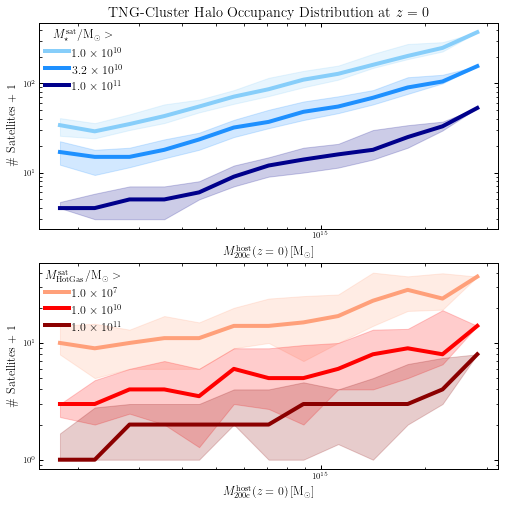

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(figsizewidth_fullpage, figsizewidth_fullpage))
colors_Mstar = ['lightskyblue', 'dodgerblue', 'darkblue']

colors_CGM = ['lightsalmon', 'red', 'darkred']

Nsats_list = [Nsats_Mstar, Nsats_CGM]
vals_list = [vals_Mstar, vals_CGM]
colors_list = [colors_Mstar, colors_CGM]

binwidth_log = 0.1

for ax_i, ax in enumerate(axs): 
    ax.set_xscale('log')
    ax.set_xlabel(M200cz0_label)
    ax.set_ylabel(r'\# Satellites + 1')
    ax.set_yscale('log')
    
    Nsats = Nsats_list[ax_i]
    vals = vals_list[ax_i]
    colors = colors_list[ax_i]
    for val_i, val in enumerate(vals):
        Nsat = Nsats[val_i]
        color = colors[val_i]
        bin_cents, y_50s, y_16s, y_84s = ru.return2dhiststats(np.log10(M200c_unique), Nsat, binwidth_log)
        
        #ax.plot(M200c_unique, Nsat, c=color, fillstyle='none')
        ax.plot(10.**(bin_cents), y_50s, c=color, ls='-', lw=4, marker='None', label=r'$%s$'%ru.latex_float(val, 2))
        ax.fill_between(10.**(bin_cents), y_16s, y_84s, color=color, alpha=0.2)
        
    if ax_i == 0:
        ax.legend(title=r'$M_\star^{\rm sat} / {\rm M_\odot} > $')
        ax.set_title(r'TNG-Cluster Halo Occupancy Distribution at $z=0$')
    else:
        ax.legend(title=r'$M_{\rm HotGas}^{\rm sat} / {\rm M_\odot} > $')
    

if savefig:
    fname = 'L680n8192TNG_all_tot_HaloOccupancyDistribution.pdf'
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight')
    

In [24]:
def plot_colored2dhist(Sim, x_key=Mstarz0_key, y_key=MHGasz0_key,
                       x_label=r'$\log_{10}\left[M_{\star}^{\rm sat}(z=0) / {\rm M_\odot}\right]$',
                       y_label=r'$\log_{10}\left[M_{\rm HotGas}^{\rm sat}(z=0) / {\rm M_\odot}\right]$',
                       x_binwidth=0.25, y_binwidth=None,
                       c_key=M200cz0_key, c_log=True,
                       cmap='viridis', c_label=r'Median Host Mass [$M_{\rm 200c}^{\rm host} / {\rm M_\odot}$]',
                       add_contours=True, savefig=False):
    """
    For the given Sim, plot the 2D log-log x-y histogram colorcoded by the median c_key. 
    Optionally can overplot the contours denoting the population.
    """
    if c_log: 
        norm = mpl.colors.LogNorm()
    else:
        norm = None

    if y_binwidth is None:
        y_binwidth = x_binwidth
        
    binwidth = 0.3
    tau_dict = Sim.tau_dict
    x = np.log10(tau_dict[x_key].copy())
    y = np.log10(tau_dict[y_key].copy())
    
    x_bins, x_bincents = ru.returnbins(x, x_binwidth)
    y_bins, y_bincents = ru.returnbins(y, y_binwidth)
    c = tau_dict[c_key].copy()
    bins = [x_bins, y_bins]
    
    statistic = scipy.stats.binned_statistic_2d(y, x, c, statistic='median', bins=[bins[1], bins[0]])
    
    extent = [bins[0][0], bins[0][-1], 
              bins[1][0], bins[1][-1]]
    
    fig, ax = plt.subplots()

    h = ax.imshow(statistic[0], norm=norm, origin='lower', aspect='auto', cmap=cmap,
                  extent=extent)
        
    cbar = fig.colorbar(h, ax=ax, label=c_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(Sim.plot_label)
    
    if add_contours:
        statistic = scipy.stats.binned_statistic_2d(y, x, np.ones(x.size), statistic='count',
                                                    bins=[bins[1], bins[0]])

        vals = statistic[0]

        # plot contours based on percentiles
        percentiles = [16, 50, 84, 95]
        levels = np.zeros(len(percentiles))
        for i, p in enumerate(percentiles):
            levels[i] = np.percentile(vals[vals > 0], p)
        
        colors = ['lightgray', 'darkgray', 'gray', 'black']
        ax.contour(x_bincents, y_bincents, vals, levels=levels, colors=colors, extend=extent)

    if (savefig):
        fname = 'L680n8192TNG_all_gasz0_%s-%s-%s.pdf'%(x_key, y_key, c_key)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
            
            
    return fig, ax

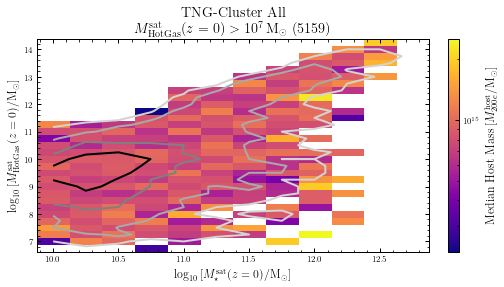

In [25]:
Sim = TNGCluster_all_gasz0
fig, ax =  plot_colored2dhist(Sim, cmap='plasma', savefig=savefig)

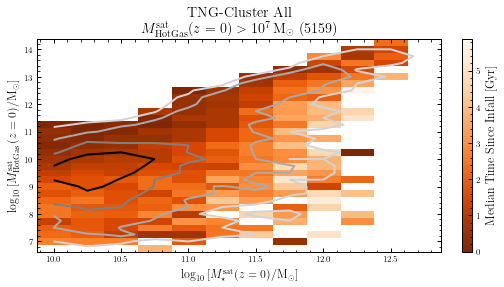

In [26]:
fig, ax = plot_colored2dhist(Sim, c_key=time_since_infall_key, c_log=False,
                             cmap='Oranges_r', c_label=r'Median Time Since Infall [Gyr]',
                             savefig=savefig)

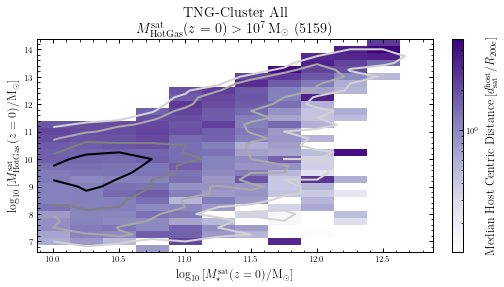

In [27]:
fig, ax = plot_colored2dhist(Sim, c_key=HCDnz0_key,
                             cmap='Purples', c_label=r'Median Host Centric Distance [$d_{\rm sat}^{\rm host}/ R_{\rm 200c}$]',
                             savefig=savefig)

In [28]:
# trim tau_dict only to include satellites with MHgas > 1.0e10
fname = 'subfind_L680n8192TNG_tau_gasz0.hdf5'
sim = 'L680n8192TNG'

TNGCluster_all_largegasz0 = TNGSim(sim, fname, all_key, gas_key)
tau_dict = TNGCluster_all_largegasz0.tau_dict

indices = tau_dict[MHGasz0_key] >= 1.0e10
for key in tau_dict.keys():
    tau_dict[key] = tau_dict[key][indices]
    
TNGCluster_all_largegasz0.plot_label = 'TNG-Cluster All \n' + r'$M_{\rm HotGas}^{\rm sat}(z=0) > 10^{10}\, {\rm M_\odot}$'
TNGCluster_all_largegasz0.save_label = 'L680n8192TNG_all_largegas'

add_time_since_infall_dset(TNGCluster_all_largegasz0)

subfindIDs = tau_dict['SubfindID']

# load input file into a dictionary
def load_grpdict():
    result = {}
    infname = 'subfind_L680n8192TNG_branches_all.hdf5'
    with h5py.File('../Output/L680n8192TNG_subfindGRP/' + infname, 'r') as f:
        for subfindID in subfindIDs:
            group_key = '%08d'%subfindID
            
            result[group_key] = {}
            for dset_key in f[group_key].keys():
                result[group_key][dset_key] = f[group_key][dset_key][:]
        f.close()
    
    return result

grp_dict = load_grpdict()
grp_dict_keys = np.array(list(grp_dict.keys()))

In [29]:
grp_dict_keys[0]

'00000001'

In [30]:
group = grp_dict[grp_dict_keys[0]]
print(group['SubhaloGasMassShells'][0], group['SubhaloColdGasMassShells'][0], group['SubhaloHotGasMassShells'][0])
print(np.log10(group['SubhaloGasMass'][0]), np.log10(group['SubhaloColdGasMass'][0]), np.log10(group['SubhaloHotGasMass'][0]))

[3.47136123e+10 2.94616310e+10 5.46493891e+10 1.00615733e+11
 1.78829443e+11 3.21294434e+11 5.60486744e+11 9.39666440e+11
 1.49419563e+12 2.03346359e+12 2.48735701e+12 3.51130773e+12
 5.02530153e+12 6.81050427e+12 8.44772671e+12 1.01689705e+13
 1.23821852e+13 1.56502946e+13 2.02024902e+13 2.11463134e+13
 1.54995136e+13 7.33692822e+12 1.34368723e+12 5.06923581e+10
 1.25829120e+08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] [       0.        0.        0.        0.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0. 41237944.        0.        0.        0.        0.
        0.        0.        0.        0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
14.13293395923055 7.615297004533076 14.132933798280327


In [31]:
rmin = 1
rmax = 1.0e3
binwidth_log = 0.1
_, radii_phys_bincents = ru.returnlogbins([rmin, rmax], binwidth_log)
radii_norm_bincents = grp_dict[grp_dict_keys[0]]['radii'][0,:] / grp_dict[grp_dict_keys[0]]['Subhalo_Rgal'][0]

def return_stacked_dict(tau_dict, dset_key, dset_bins):
    """
    Given the tau_dict, dset_key, and dset_dset_bins, bin all subhalos within
    the tau_dict by the dset_key and dset_dset_bins. Then within the stack,
    calculate the medians, 16th, and 84th percentiles of the densities both
    in normalized and physical radial coordinates. Note that this assumes linear
    interpolation between the nonzero density entries. 
    Resulting dictionary takes indices as keys, which lead to another dictionary 
    that takes '50_phys', '16_phys', '84_phys', '50_norm', '16_norm', '84_norm',
    and 'Ngal'. 'Ngal' is an integer, and all other entries are 1D arrays 
    corresponding to the global radii_phys_bincents and radii_norm_bincents 1D arrays.
    """
    
    result_dict = {}
    
    for bin_i in range(len(dset_bins)-1):
        result_dict[bin_i] = {}
        indices = ((tau_dict[dset_key] > dset_bins[bin_i]) &
                   (tau_dict[dset_key] < dset_bins[bin_i+1]))

        # initalize the outputs
        result_dict[bin_i]['50_phys'] = np.zeros((len(indices[indices]), len(radii_phys_bincents)), dtype=float) - 1.
        result_dict[bin_i]['16_phys'] = result_dict[bin_i]['50_phys'].copy()
        result_dict[bin_i]['84_phys'] = result_dict[bin_i]['50_phys'].copy()
        result_dict[bin_i]['50_norm'] = np.zeros((len(indices[indices]), len(radii_norm_bincents)), dtype=float) - 1.
        result_dict[bin_i]['16_norm'] = result_dict[bin_i]['50_norm'].copy()
        result_dict[bin_i]['84_norm'] = result_dict[bin_i]['50_norm'].copy()

        phys = np.zeros((len(indices[indices]), len(radii_phys_bincents)), dtype=float) - 1.
        norm = np.zeros((len(indices[indices]), len(radii_norm_bincents)), dtype=float) - 1.

        for index, subfindID in enumerate(tau_dict['SubfindID'][indices]):
            key = '%08d'%subfindID
            group = grp_dict[key]
            radii = group['radii'][0,:].copy()
            rgal = group['Subhalo_Rgal'][0].copy()
            densities = group['SubhaloDensityShells'][0,:].copy()
            nonz0_indices = densities > 0

            # interpolate the nonz0 densities and radii at the bincents
            phys[index,:] = np.interp(radii_phys_bincents, radii[nonz0_indices], densities[nonz0_indices])
            norm[index,:] = np.interp(radii_norm_bincents, radii[nonz0_indices]/rgal, densities[nonz0_indices])

        # finish loop of indices, save final results
        if np.min(phys) == -1:
            raise ValueError('not all indices of densities have been assigned.')

        result_dict[bin_i]['50_phys'] = np.median(phys, axis=0)
        result_dict[bin_i]['16_phys'] = np.percentile(phys, 16, axis=0)
        result_dict[bin_i]['84_phys'] = np.percentile(phys, 84, axis=0)

        result_dict[bin_i]['50_norm'] = np.median(norm, axis=0)
        result_dict[bin_i]['16_norm'] = np.percentile(norm, 16, axis=0)
        result_dict[bin_i]['84_norm'] = np.percentile(norm, 84, axis=0)

        result_dict[bin_i]['Ngal'] = len(norm)
        
    # finish loop over bins. return to main
    return result_dict


def plot_stacked_dict(Sim, stacked_dict, dset_key, dset_bins, dset_label, colors, radii='norm', savefig=False):
    """
    Plot the stacked_dict given the dict, dset_bins, and label.
    If radii=='norm', then use the normalized radial coordinates.
    If radii=='phys', use physical radial coordinates.
    """
    if radii == 'norm':
        x_label = r'Distance [$ r / 2R_{\rm half}^\star$]'
        radii_bincents = radii_norm_bincents
    elif radii == 'phys':
        x_label = r'Distance [$r / {\rm kpc}$]'
        radii_bincents = radii_phys_bincents
    else:
        raise ValueError('invalid radii value %s. Accepted values are norm and phys'%radii)
        
    if len(colors) < len(stacked_dict.keys()):
        raise ValueError('too few colors given')
    
    fig, ax = plt.subplots()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(x_label)
    ax.set_ylabel(r'Gas Densitity [$\rho_{\rm Gas}^{\rm sat}({\rm shells}) / {\rm M_\odot\, kpc^{-3}}$]' )

    for i, bin_key in enumerate(stacked_dict.keys()):
        color = colors[i]
        densities_50 = stacked_dict[bin_key]['50_%s'%radii]
        densities_16 = stacked_dict[bin_key]['16_%s'%radii]
        densities_84 = stacked_dict[bin_key]['84_%s'%radii]
        Ngal = stacked_dict[bin_key]['Ngal']
        ax.plot(radii_bincents, densities_50, '-', color=color, label=r'$[%.2g, %.2g)\ (%d)$'%(dset_bins[i], dset_bins[i+1], Ngal))
        ax.fill_between(radii_bincents, densities_16, densities_84, color=color, alpha=0.2)

    ax.legend(title=dset_label)
    ax.set_title(Sim.plot_label)
    
    if (savefig):
        fname = '%s_MGasRadProf_Stack-%s_%s.pdf'%(Sim.save_label, dset_key, radii)
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')
    
    return fig, ax


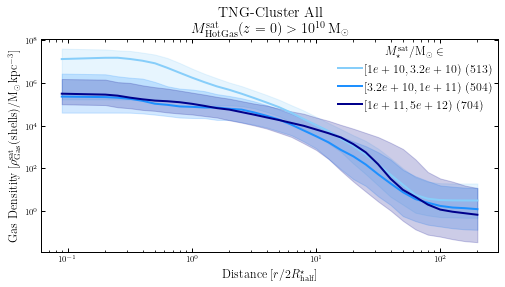

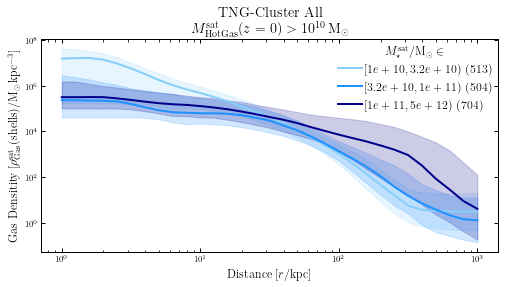

In [32]:
dset_key = Mstarz0_key
dset_bins = [10.**(10.0), 10.**(10.5), 10.**(11.0), 10.**(12.7)]
dset_label = r'$M_\star^{\rm sat} / {\rm M_\odot} \in$'
colors = ['lightskyblue', 'dodgerblue', 'darkblue']

stacked_dict = return_stacked_dict(tau_dict, dset_key, dset_bins)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='norm', savefig=savefig)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='phys', savefig=savefig)

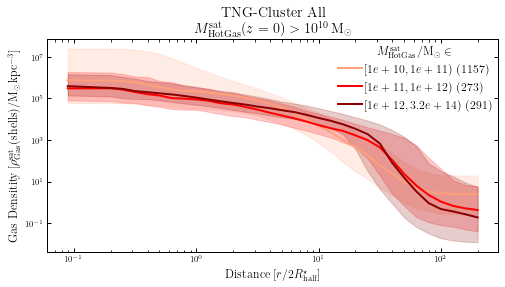

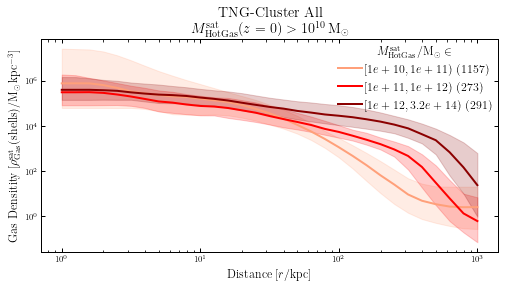

In [33]:
dset_key = MHGasz0_key
dset_bins = [10.**(10.0), 10.**(11.0), 10.**(12.0), 10.**(14.5)]
dset_label = r'$M_{\rm HotGas}^{\rm sat} / {\rm M_\odot} \in$'
colors = ['lightsalmon', 'red', 'darkred']

stacked_dict = return_stacked_dict(tau_dict, dset_key, dset_bins)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='norm', savefig=savefig)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='phys', savefig=savefig)

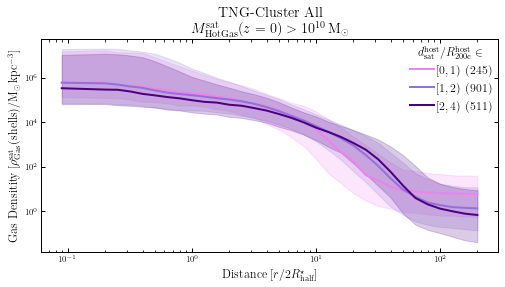

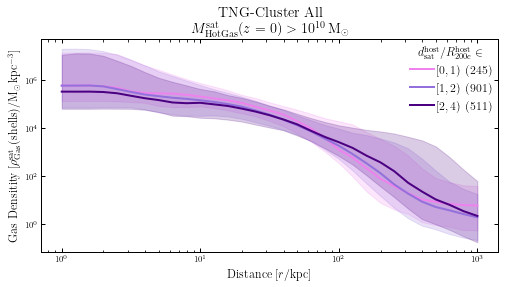

In [34]:
dset_key = HCDnz0_key
dset_bins = [0.0, 1.0, 2.0, 4.0]
dset_label = r'$d_{\rm sat}^{\rm host} / R_{\rm 200c}^{\rm host} \in$'
colors = ['violet', 'mediumpurple', 'indigo']

stacked_dict = return_stacked_dict(tau_dict, dset_key, dset_bins)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='norm', savefig=savefig)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='phys', savefig=savefig)

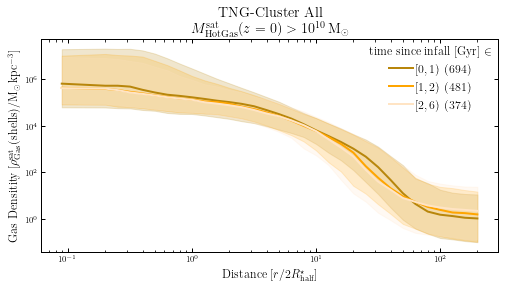

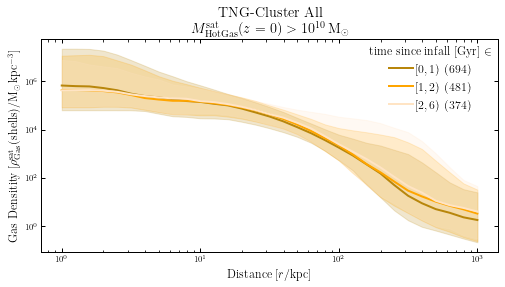

In [35]:
dset_key = time_since_infall_key
dset_bins = [0.0, 1.0, 2.0, 6.0]
dset_label = r'time since infall [Gyr] $\in$'
colors = ['darkgoldenrod', 'orange', 'bisque']

stacked_dict = return_stacked_dict(tau_dict, dset_key, dset_bins)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='norm', savefig=savefig)

fig, ax = plot_stacked_dict(TNGCluster_all_largegasz0, stacked_dict, dset_key, dset_bins, dset_label, colors=colors, radii='phys', savefig=savefig)

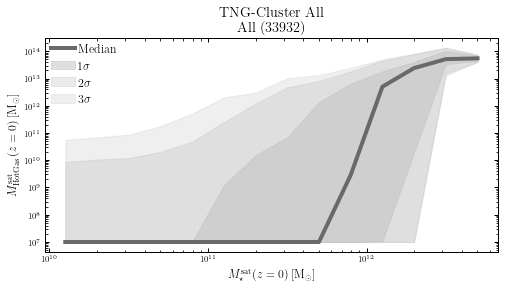

In [36]:
Sim = TNGCluster_all

tau_dict = Sim.tau_dict
Mstar = tau_dict[Mstarz0_key].copy()
MHGas = tau_dict[MHGasz0_key].copy()

MHGas_lolim = 1.0e7
MHGas[MHGas < MHGas_lolim] = MHGas_lolim

mass_binwidth = 0.2

percentiles = [0.15, 2.5, 16, 50, 84, 97.5, 99.85]
sigmas = [3, 2, 1]
stats = ru.return2dhiststats_dict(np.log10(Mstar), np.log10(MHGas), mass_binwidth, percentiles)
bin_cents = 10**(stats['bin_cents'])

fig, ax = plt.subplots()

for i, sigma in enumerate(sigmas):
    lo_percentile = percentiles[i]
    hi_percentile = percentiles[-(i+1)]
    
    y_los = 10.**(stats[lo_percentile])
    y_his = 10.**(stats[hi_percentile])
    
    ax.fill_between(bin_cents, y_los, y_his, color=Sim.plotkwargs['color'], alpha=1./(sigma+1.), label='%d'%sigma + r'$\sigma$')

y_50s = 10.**(stats[50])
ax.plot(bin_cents, y_50s, c='dimgray', ls='-', lw=4, marker='None', label='Median')
  

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(Sim.plot_label)
ax.set_xlabel(Mstarz0_label)
ax.set_ylabel(MHGasz0_label)
h_orig, l_orig = ax.get_legend_handles_labels()
h_new = [h_orig[0]]
l_new = [l_orig[0]]
for index in range(1, len(h_orig)):
    h_new.append(h_orig[-index])
    l_new.append(l_orig[-index])
    print()
ax.legend(h_new, l_new)

if savefig:
    fname = '%s_%s-%s.pdf'%(Sim.save_label, MHGasz0_key, Mstarz0_key)
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight')

loval = 1.0e-6

fgas_z0_label = r'$f_{\rm Gas}^{\rm sat} \equiv M_{\rm Gas}^{\rm sat} / M_{\rm tot}^{\rm sat}$'
fCgas_z0_label = r'$f_{\rm ColdGas}^{\rm sat} \equiv M_{\rm ColdGasas}^{\rm sat} / M_{\rm tot}^{\rm sat}$'
fHgas_z0_label = r'$f_{\rm HotGas}^{\rm sat} \equiv M_{\rm HotGas}^{\rm sat} / M_{\rm tot}^{\rm sat}$'

fgas_z0_labels = [fgas_z0_label,
                  fCgas_z0_label,
                  fHgas_z0_label]


fgas_z0_keys = [fgas_z0_key,
                fCgas_z0_key,
                fHgas_z0_key]

Sims = [TNGCluster_all, TNGCluster_clean, TNGCluster_PP]


for Sim_i, Sim in enumerate(Sims):
    tau_dict = Sim.tau_dict
    Mstar = tau_dict[Mstarz0_key]

    for fgas_i, fgas_key in enumerate(fgas_z0_keys):
        fgas_label = fgas_z0_labels[fgas_i]
        
        fgas = tau_dict[fgas_key].copy()
        fgas[fgas <= loval] = loval
        
        bin_cents, y_50s, y_16s, y_84s = ru.return2dhiststats(np.log10(Mstar), np.log10(fgas), mass_binwidth)

        fig, ax = plt.subplots()
        ax.plot(Mstar, fgas, c=Sim.plotkwargs['color'], fillstyle='none', ms=1)
        ax.plot(10.**(bin_cents), 10.**(y_50s), c=Sim.plotkwargs['color'], ls='-', lw=4, marker='None')
        ax.fill_between(10.**(bin_cents), 10.**(y_16s), 10.**(y_84s), color=Sim.plotkwargs['color'], alpha=0.4)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(Sim.plot_label)
        ax.set_xlabel(Mstarz0_label)
        ax.set_ylabel(fgas_label)
        
        fname = '%s_%s-Mstarz0.pdf'%(Sim.save_label, fgas_key)
        if savefig:
            for direc in direc_list:
                fig.savefig(direc + fname, bbox_inches='tight')


In [37]:
sim = 'TNG300-1'
basePath = ru.ret_basePath(sim)
GroupFirstSub = il.groupcat.loadHalos(basePath, 99, fields='GroupFirstSub')
haloIDs = np.arange(GroupFirstSub.size)

subhalo_fields = ['SubhaloMassInRadType', 'SubhaloMass', 'SubhaloMassType']
subhalos = il.groupcat.loadSubhalos(basePath, 99, fields=subhalo_fields)

In [38]:
Mstar = subhalos['SubhaloMassInRadType'][:,4] * 1.0e10 / 0.6774
subhaloIDs = np.where(Mstar > 1.0e10)[0]

isin = np.isin(subhaloIDs, GroupFirstSub, assume_unique=True)
centralIDs = subhaloIDs[isin]
satelliteIDs = subhaloIDs[~isin]

centrals_Mstar = Mstar[centralIDs]
centrals_GasMass = subhalos['SubhaloMassType'][centralIDs,0] * 1.0e10 / 0.6774
centrals_TotMass = subhalos['SubhaloMass'][centralIDs] * 1.0e10 / 0.6774
centrals_fgas = centrals_GasMass / centrals_TotMass
centrals_fgas[centrals_fgas < loval] = loval

satellite_Mstar = Mstar[satelliteIDs]
satellite_GasMass = subhalos['SubhaloMassType'][satelliteIDs,0] * 1.0e10 / 0.6774
satellite_TotMass = subhalos['SubhaloMass'][satelliteIDs] * 1.0e10 / 0.6774
satellite_fgas = satellite_GasMass / satellite_TotMass
satellite_fgas[satellite_fgas < loval] = loval

xs = [centrals_Mstar, satellite_Mstar]
ys = [centrals_fgas, satellite_fgas]
colors = ['black', 'orange']
labels = ['centrals', 'satellites']

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('TNG300-1 All')
ax.set_xlabel(Mstarz0_label)
ax.set_ylabel(r'$f_{\rm gas}^{\rm subhalo} \equiv M_{\rm gas}^{\rm subhalo} / M_{\rm tot}^{\rm subhalo}$')

for i, x in enumerate(xs):
    y = ys[i]
    color = colors[i]
    label = labels[i]

    bin_cents, y_50s, y_16s, y_84s = ru.return2dhiststats(np.log10(x), np.log10(y), mass_binwidth)

    ax.plot(x, y, c=color, fillstyle='none', ms=1, alpha=0.2, mew=0.5)
    ax.plot(10.**(bin_cents), 10.**(y_50s), c=color, ls='-', lw=4, marker='None', label=label)
    ax.fill_between(10.**(bin_cents), 10.**(y_16s), 10.**(y_84s), color=color, alpha=0.4)

ax.legend()
if savefig:
    fname = 'TNG300-1_%s-Mstarz0.pdf'%(fgas_z0_key)
    for direc in direc_list:
        fig.savefig(direc + fname, bbox_inches='tight')

In [39]:
### plot tstrip histograms binned by various parameters ### 
def plot_tstrip_RPS_multipanel(Sim, m200cz0_bin_i=2, savefig=False):
    """
    Create the multipanel figure for tstrip
    top panel is tstrip binned by m200cz0
    bottom panels take one bin of m200cz0 and show
    the same results using the infall time definition,
    and the other two panels further bin by mstarz0 and infall time.
    Returns the fig, and plt.gca could be used to the axes
    """
    
    def rewrite_legend(ax):
        """
        find the existing legend on ax, update properties, and rewrite
        """
        
        leg     = ax.get_legend()
        handles = leg.get_patches()
        texts   = leg.get_texts()
        title   = leg.get_title().get_text()
        labels  = []
        for text in texts:
            labels.append(text.get_text())

        if M200cz0_label in title:
            title = r'$\tau_{\rm RPS}$ calculated via'
            labels = [r'RPS sRPS',
                      r'RPS tot']
        elif Mstarz0_label in title:
            title = r'$\lg[M_\star^{\rm sat}(z=0)]\in$'
        elif tau0_label in title:
            title = r'Infall Time [Gyr] $\in$'
        elif fgas_infall_label in title:
            title = r'$\lg[f_{\rm ColdGas}(\tau_0)] \in$'
        elif SCGM_infall_label in title:
            title = r'$\lg[M_{\rm ColdGas}^{\rm sat}(\tau_0)] \in$'
        elif Napopass_tau100_label in title:
            title = r'$N_{\rm orbits}(\tau_{100}) \in$'
        else:
            print('rewrite legend not supported. returning')
            return
        
        leg.set_visible(False)
        ax.legend(handles, labels, title=title, fontsize='x-small', title_fontsize='x-small')
        
        return ax
    
    text_kwargs_panel = dict(ha='right', va='top', ma='right', fontsize='x-small')

    x_key   = tstrip_key
    bin_key = M200cz0_key
    x_label = tstrip_label_long
    
    x_vals   = Sim.tau_dict[x_key]
    bin_vals = np.log10(Sim.tau_dict[bin_key])
        
    bins          = Sim.tstrip_histbins_dict[x_key][bin_key]['bins']
    bin_label     = Sim.tstrip_histbins_dict[x_key][bin_key]['label']
    bin_savelabel = Sim.tstrip_histbins_dict[x_key][bin_key]['savelabel']
    
    figsizeheight = figsizewidth / 1.5
    fig = plt.figure(constrained_layout=True, figsize=(figsizewidth, figsizeheight))
    
    gs = gridspec.GridSpec(2, 3, figure=fig)
    
    # first axis: M200c(z=0) bins -- use all three colunmns of the first row
    ax1 = fig.add_subplot(gs[0,:])
    
    ax1 = plot_binnedhist_panel(Sim, ax1, x_key, bin_key, add_legend=True)
    
    # for the bottom row, we only use one of the M200cz0 bins
    bins_plot   = bins[m200cz0_bin_i:m200cz0_bin_i+2]
    bin_indices = ((bin_vals >= bins_plot[0]) & (bin_vals < bins_plot[1]))
    
    y0_text = 0.575
    y1_text = 0.475
    x0_text = 0.95
    
    # second axis: tstrip definition comparison -- first column
    ax2 = fig.add_subplot(gs[1,0])
    
    bin_key = SCGM_infall_key
    
    ax2 = plot_binnedhist_panel(Sim, ax2, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    ax2 = rewrite_legend(ax2)
    
    textkwargs = dict(transform=ax2.transAxes, **text_kwargs_panel, **text_kwargs)
    ax2.text(x0_text, y0_text, r'%s '%bin_label, **textkwargs)
    ax2.text(x0_text, y1_text, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    
    # third axis: Mstarz0 -- second column
    ax3 = fig.add_subplot(gs[1,1], sharey=ax2)
    
    bin_key = Mstarz0_key
    
    ax3 = plot_binnedhist_panel(Sim, ax3, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    ax3 = rewrite_legend(ax3)
        
    textkwargs = dict(transform=ax3.transAxes, **text_kwargs_panel, **text_kwargs)
    ax3.text(x0_text, y0_text, r'%s'%bin_label, **textkwargs)
    ax3.text(x0_text, y1_text, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)

    # fourth axis: tau0_infall -- third column
    ax4 = fig.add_subplot(gs[1,2], sharey=ax3)
    #ax4.tick_params(labelleft=False)
    
    bin_key = Napopass_tau100_key
    
    ax4 = plot_binnedhist_panel(Sim, ax4, x_key, bin_key,
                                preset_indices=bin_indices, add_legend=True)
    
    ax4 = rewrite_legend(ax4)

    textkwargs = dict(transform=ax4.transAxes, **text_kwargs_panel, **text_kwargs)
    ax4.text(x0_text, y0_text, r'%s'%bin_label, **textkwargs)
    ax4.text(x0_text, y1_text, r'$\in [%.1f, %.1f)$'%(bins_plot[0], bins_plot[1]), **textkwargs)
    
    fig.text(0.5, -0.01, x_label, va='center', ha='center', fontsize='large')
    fig.text(-0.02, 0.5, Nbranches_label, rotation='vertical', va='center', ha='center', fontsize='large')
    ax1.set_title(r'%s'%Sim.plot_label)
    
    if (savefig):
        bin_key = M200cz0_key
        fname = '%s_%s_multipanel_%s_%.1f-%.1f.pdf'%(Sim.save_label,
                                                     tstrip_key,
                                                     bin_key,
                                                     bins_plot[0],
                                                     bins_plot[1])
        for direc in direc_list:
            fig.savefig(direc + fname, bbox_inches='tight')

    return fig


def plot_binnedhist_panel(Sim, ax, x_key, bin_key, 
                          preset_indices=None, use_preset_bins=True, add_legend=False):
    """
    fill an ax with histograms of tstrip (x_key), binned by some other parameter bin_key.
    Note that x_key should be one of the t_strip keys.
    preset_indices slices x before binning by bin_key.
    use_preset_bins uses the bins defined in Sim.tstrip_histbins_dict[x_key][bin_key]['bins'].
    If False, then uses [0, 33, 67, 100] percentiles. 
    Optionally add the legend as well.
    Returns the ax.
    """
    
    x_vals   = Sim.tau_dict[x_key][preset_indices]
    bin_vals = Sim.tau_dict[bin_key][preset_indices]
    indices  = ((x_vals >= 0) & (bin_vals >= 0))
    x_vals   = x_vals[indices]
    
    bin_label = Sim.tstrip_histbins_dict[x_key][bin_key]['label']
    # linear or log binning for bin_vals? 
    if ('T' in bin_key) or (Napopass_tau100_key in bin_key):
        bin_vals = bin_vals[indices]
        legend_title = r'%s $\in$'%bin_label
    elif ('M' in bin_key) or ('GasFraction' in bin_key):
        bin_vals = np.log10(bin_vals[indices])
        legend_title = r'$\log_{10}\big[$%s$\big] \in$'%bin_label
    else:
        print('bin_key %s not supported. returning'%bin_key)
        return
    
    # assuming linear binning for t_strip spanning all time 
    x_binwidth         = 0.5 # set manually for now 
    x_bins, x_bincents = ru.returnbins([0.01, 13.99], x_binwidth)       

    if (use_preset_bins):
        bins = Sim.tstrip_histbins_dict[x_key][bin_key]['bins']
    else:
        bins = np.percentile(bin_vals, [0, 33, 67, 100])
        bins[0]  -= 0.01
        bins[-1] += 0.01 
    bin_indices = np.digitize(bin_vals, bins)
    
    histkwargs_list = Sim.tstrip_histbins_dict[x_key][bin_key]['histkwargs_list']
    
    for bin_i in range(len(bins)-1):

        histkwargs = histkwargs_list[bin_i]
                        
        plot_indices = bin_indices == (bin_i + 1)
        
        x_plot = x_vals[plot_indices]
        Nbin   = len(x_plot)
        
        # if there are no data, then ignore and continue 
        if Nbin == 0:
            continue
        
        labeltext = r'$[%.1f, %.1f)\ (%d)$'%(bins[bin_i],
                                             bins[bin_i+1], Nbin)    

        ax.hist(x_plot, x_bins, label=labeltext, **histkwargs)
        
        # add  a vertical line at median
        ax.axvline(np.median(x_plot), color=histkwargs['color'], **median_kwargs)
    # finish loop over bins
    
    if (add_legend):
        ax.legend(title=legend_title, **legend_kwargs)
        
    return ax
